
Deep Learning Project. Group 10.

Thomas Therkelsen (ththe20)
Simon Vinkel (sivin11)
Marc Egedal (maege17)

Finding relevant image infected with pnumonia. Firsly understanding the image.

x-rays images are presented in greyscale.
Pnumonia is presented by areas of opacity.
Training images are classified binary as with or without pneumonia
On all images, a reverse R is present on the left hand side.
A trend is showing that a larger image size indicates "normal"
Below are the necessary imports for this program.

In [19]:
import tensorflow.keras as tf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import math
import shutil
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
import sys
import os
from os import listdir
from tensorflow.python.client import device_lib


import pathlib


%matplotlib inline
mpl.rcParams['figure.dpi']= 200

print("GPU available? ", len(device_lib.list_local_devices())>0)

GPU available?  True


Data preprocessing

Research on this done by the whole group, implementation done by Thomas

In [12]:
# define directory paths
source_dir = "data/"
data_dir = "dataset/"
train_dir = data_dir+"train/"
test_dir = data_dir+"test/"
val_dir = data_dir+"validation/"

# if the folder does not already exist
if not os.path.exists(data_dir):
    # create it
    os.makedirs(data_dir)
    print(data_dir, " created")
    
if not os.path.exists(train_dir):
    # create it
    os.makedirs(train_dir)
    print(train_dir, " created")
if not os.path.exists(train_dir+"normal/"):
    os.makedirs(train_dir+"normal/")
    print(train_dir+"normal", " created")
if not os.path.exists(train_dir+"pneumonia/"):
    os.makedirs(train_dir+"pneumonia/")
    print(train_dir+"pneumonia/", " created")

if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    print(test_dir, " created")
if not os.path.exists(test_dir+"normal/"):
    os.makedirs(test_dir+"normal/")
    print(test_dir+"normal/", " created")
if not os.path.exists(test_dir+"pneumonia/"):
    os.makedirs(test_dir+"pneumonia/")
    print(test_dir+"pneumonia/", " created")

if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    print(val_dir, " created")
if not os.path.exists(val_dir+"normal/"):
    os.makedirs(val_dir+"normal/")
    print(val_dir+"normal/", " created")
if not os.path.exists(val_dir+"pneumonia/"):
    os.makedirs(val_dir+"pneumonia/")
    print(val_dir+"pneumonia/", " created")

count = 0
# count images in data folder (should only be non-zero on first run of the code)
for path in os.listdir(source_dir):
    # check if current path is a file
    if os.path.isfile(os.path.join(source_dir, path)):
        # count it
        count += 1
        # if it isn't an image, delete it
        if(not path.endswith(".jpg")):
            print('deleting ', source_dir+path)
            os.remove(source_dir+path)
print('files in data folder (should only be nonzero on your first run of this code):', count)

num_files = count

train_percent = 80
val_percent = 10
test_percent = 10

num_train = int(math.floor(num_files * (train_percent / 100)))
num_val = int(math.floor(num_files * (val_percent / 100)))
num_test = int(math.floor(num_files * (test_percent / 100)))

# Using for loop to randomly choose multiple files
# moving test_percent % to the validation folder
for file in range(num_test):
    random_file=random.choice(os.listdir(source_dir))
    source_file="%s/%s"%(source_dir,random_file)
    if (random_file.endswith("a.jpg")):
        shutil.move(source_file,test_dir+"pneumonia/")
    else:
        shutil.move(source_file,test_dir+"normal/")

# moving val_percent % to the test folder
for file in range(num_val):
    random_file=random.choice(os.listdir(source_dir))
    source_file="%s/%s"%(source_dir,random_file)
    if (random_file.endswith("a.jpg")):
        shutil.move(source_file,val_dir+"pneumonia/")
    else:
        shutil.move(source_file,val_dir+"normal/")
        
# moving train_percent % files to the training folder
for file in os.listdir(source_dir):
    if (file.endswith("a.jpg")):
        shutil.move(source_dir+file,train_dir+"pneumonia/")
    else:
        shutil.move(source_dir+file,train_dir+"normal/")

files in data folder (should only be nonzero on your first run of this code): 0


In [13]:
image_size = (256, 256)
input_shape = (256, 256, 1)

num_epochs = 25
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=45,
    zoom_range=0.2,
    fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1/255.0)

test_datagen = ImageDataGenerator(rescale=1/255.0)


train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=image_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=int(time.time())
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=image_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="binary",
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=image_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='binary'
)

Found 1760 images belonging to 2 classes.
Found 220 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


In [16]:
inputs = tf.Input(input_shape)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(inputs)

x1 = Conv2D(16, kernel_size = (3,3), activation = 'relu', name = "kernel1", padding = "same")(x)

x2 = Conv2D(16, kernel_size = (3,3), activation = 'relu', name = "kernel2", padding = "same")(x)

x = Concatenate()([x1, x2])
x = MaxPooling2D(pool_size=(3,3), strides = (1,1), padding = "same")(x)

x = Flatten()(x)

outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs, name="pneumonia_model")

print('layers added')
model.summary()
print("model parameters:")
print("batch size: ", batch_size)
print("epochs: ", num_epochs)
print("steps per epoch: ", steps_per_epoch)
print("validation steps: ", validation_steps)


# For a twin-class classification problem
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['Accuracy'])
print('model compiled')

layers added
Model: "pneumonia_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 254, 254, 16  160         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 kernel1 (Conv2D)               (None, 254, 254, 16  2320        ['conv2d_4[0][0]']               
                                )                                      

In [17]:
history = model.fit(train_generator,                          # train_generator returns a tuple with what will be our train_data and train_labels
                    verbose=1,
                    epochs = num_epochs,
                    validation_steps=val_generator.n//val_generator.batch_size,     # Validation steps = number of val-data/batch-size (int division)
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size   # Steps steps = number of train-data/batch-size (int division)
                    )

score = model.evaluate(val_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
55/55 [==============================] - 28s 468ms/step - loss: 3.0284 - Accuracy: 0.6676 - val_loss: 0.3393 - val_Accuracy: 0.8646
Epoch 2/25
55/55 [==============================] - 24s 427ms/step - loss: 0.3435 - Accuracy: 0.8693 - val_loss: 0.2412 - val_Accuracy: 0.9219
Epoch 3/25
55/55 [==============================] - 24s 433ms/step - loss: 0.3396 - Accuracy: 0.8665 - val_loss: 0.2189 - val_Accuracy: 0.9219
Epoch 4/25
55/55 [==============================] - 24s 433ms/step - loss: 0.2512 - Accuracy: 0.9068 - val_loss: 0.2198 - val_Accuracy: 0.9115
Epoch 5/25
55/55 [==============================] - 25s 448ms/step - loss: 0.2322 - Accuracy: 0.9153 - val_loss: 0.2405 - val_Accuracy: 0.9427
Epoch 6/25
55/55 [==============================] - 24s 434ms/step - loss: 0.2546 - Accuracy: 0.9114 - val_loss: 0.1906 - val_Accuracy: 0.9479
Epoch 7/25
55/55 [==============================] - 25s 448ms/step - loss: 0.2436 - Accuracy: 0.9080 - val_loss: 0.1930 - val_Accuracy: 0.9479

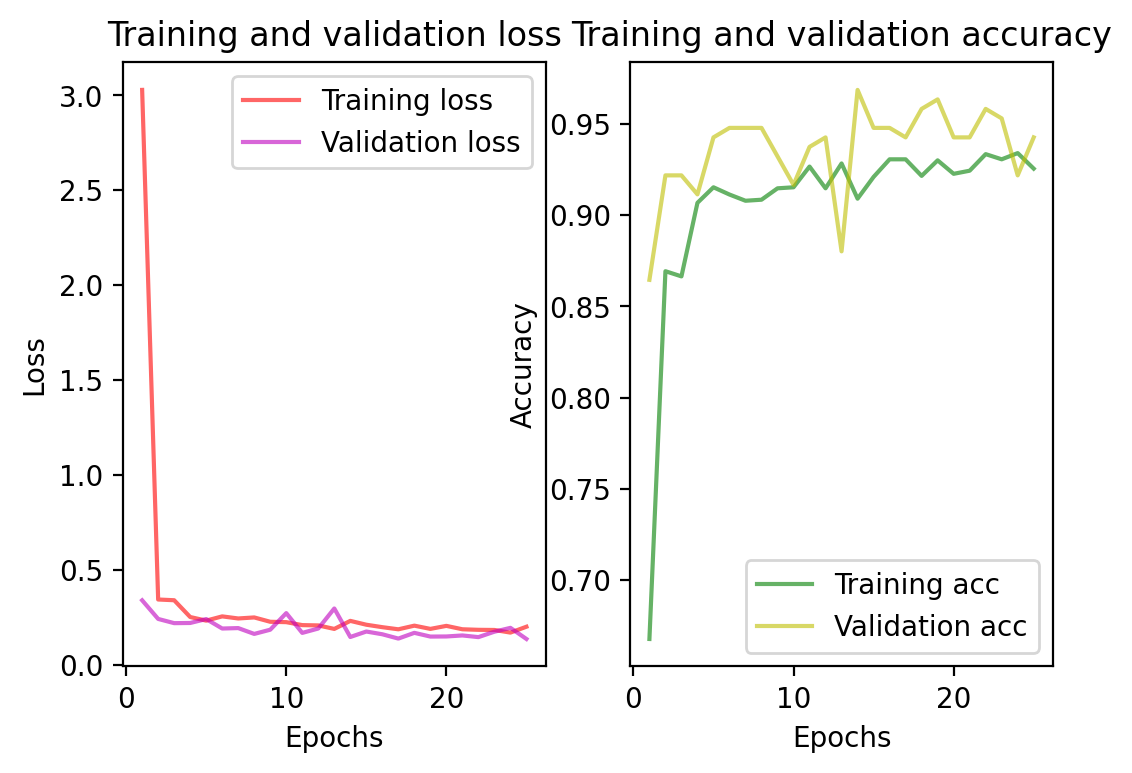

In [20]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['Accuracy']
val_acc_values = history_dict['val_Accuracy']
epochs = range(1, len(loss_values) + 1)
# 'bo' is for blue dot, 'b' is for solid blue line

plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'r-', label='Training loss', alpha=0.6)
plt.plot(epochs, val_loss_values, 'm-', label='Validation loss', alpha=0.6)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'g-', label='Training acc', alpha=0.6)
plt.plot(epochs, val_acc_values, 'y-', label='Validation acc', alpha=0.6)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()